# Model testing 18/01
This model was trained for 10 iterations using a normalization scheme subtracting the average row mean from every row and dividing every row by the average standard deviation.

In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [2]:
sample_length = 128


Testing on house 2

In [3]:
aggregate_power = pd.read_csv('../master_data/house_2/channel_1.dat', header = None,
                                names = ["Time","Power"], delim_whitespace = True,
                                index_col = 0)
aggregate_power.index = pd.to_datetime(aggregate_power.index,unit='s')

kettle_power = pd.read_csv('../master_data/house_2/channel_8.dat', header = None,
                                names = ["Time","Power"], delim_whitespace = True,
                                index_col = 0)


kettle_power.head()

/home/bjornif/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,Power
Time,
1361116822,0
1361116825,0
1361116831,0
1361116837,0
1361116843,0


In [4]:
def get_activations(power_series, min_off_duration=30, min_on_duration=12,
                        border=1, power_threshold=200):
    activations = []
    signal_start = None
    signal_end = None
    no_signal = 0
    current_signal = []
    series_length = len(power_series)
    series_length_percent = int(len(power_series)/100)
    measurements_processed = 0
    
    power_series.index = pd.to_datetime(power_series.index,unit='s')
    min_off_duration = pd.Timedelta(str(min_off_duration) + 's')
    min_on_duration = pd.Timedelta(str(min_off_duration) + 's')
    timestep = pd.Timedelta('6s')
    
    for time in power_series.index:
        measurement = power_series.loc[time]['Power']
        measurements_processed +=1
        
        if measurements_processed % series_length_percent == 0:
            print(str(measurements_processed/series_length_percent) + '%')
        
        if (measurement >= power_threshold):
            if signal_start is None:
                signal_start = time - timestep
            no_signal = 0
            current_signal.append(measurement)
            signal_end = time + timestep
            
        else:
            if signal_end is not None:
                no_signal = time - signal_end
                if (no_signal >= min_off_duration) and (signal_start is not None):
                    if (signal_end - signal_start) > min_on_duration:
                        mean_power = np.mean(current_signal)
                        activations.append([signal_start,signal_end,mean_power])
                    current_signal = []
                    signal_start = None
                    signal_end = None
    
    return activations

In [5]:
kettle_activations = get_activations(kettle_power)

1.0%
2.0%
3.0%
4.0%
5.0%
6.0%
7.0%
8.0%
9.0%
10.0%
11.0%
12.0%
13.0%
14.0%
15.0%
16.0%
17.0%
18.0%
19.0%
20.0%
21.0%
22.0%
23.0%
24.0%
25.0%
26.0%
27.0%
28.0%
29.0%
30.0%
31.0%
32.0%
33.0%
34.0%
35.0%
36.0%
37.0%
38.0%
39.0%
40.0%
41.0%
42.0%
43.0%
44.0%
45.0%
46.0%
47.0%
48.0%
49.0%
50.0%
51.0%
52.0%
53.0%
54.0%
55.0%
56.0%
57.0%
58.0%
59.0%
60.0%
61.0%
62.0%
63.0%
64.0%
65.0%
66.0%
67.0%
68.0%
69.0%
70.0%
71.0%
72.0%
73.0%
74.0%
75.0%
76.0%
77.0%
78.0%
79.0%
80.0%
81.0%
82.0%
83.0%
84.0%
85.0%
86.0%
87.0%
88.0%
89.0%
90.0%
91.0%
92.0%
93.0%
94.0%
95.0%
96.0%
97.0%
98.0%
99.0%
100.0%


In [6]:
kettle_activations_pd = pd.DataFrame(kettle_activations, columns = ['start','end','mean_power'])
kettle_activations_pd['start'] = pd.to_datetime(kettle_activations_pd['start'])
kettle_activations_pd['end'] = pd.to_datetime(kettle_activations_pd['end'])

kettle_activations_pd.head()

,start,end,mean_power
0,2013-04-17 08:01:11,2013-04-17 08:03:11,2846.210526
1,2013-04-17 16:23:28,2013-04-17 16:26:22,3016.071429
2,2013-04-17 19:11:30,2013-04-17 19:15:12,2897.971429
3,2013-04-17 20:40:15,2013-04-17 20:43:21,2998.500000
4,2013-04-18 15:32:01,2013-04-18 15:35:01,3007.241379


2013-04-21 08:41:28 2013-04-21 08:45:10


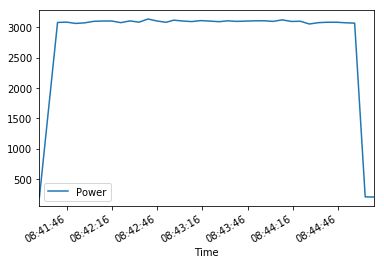

In [7]:
for _ in range(1):
    dice = np.random.randint(0,100)
    start = kettle_activations_pd.iloc[dice]['start']
    end = kettle_activations_pd.iloc[dice]['end']
    print(start,end)
    aggregate_power[start:end].plot()
    plt.show()

In [8]:
def clean_power_series(aggregate_power, activations):
    
    temp_ap = aggregate_power.copy()
    
    n = activations.shape[0]

    #pcent = int(n/100)
    ap_sans_activations = pd.DataFrame()
    
    ap_sans_activations.append(temp_ap[:activations['start'][0]])
    
    for i in range(1,n):
        ap_sans_activations = ap_sans_activations.append(temp_ap[activations['end'][i-1]:activations['start'][i]])
    
    ap_sans_activations.append(temp_ap[activations['end'][i]:])
    
    return ap_sans_activations


def create_training_set(aggregate_power, activations, ap_sans_activations = None, sample_length = 128, pad = 1024):
    training_set = pd.DataFrame(columns = np.linspace(0,1,sample_length))
    training_set_response = pd.DataFrame(columns = ['start','end','mean_power'])

    #aggregate power sans the activation intervals
    if ap_sans_activations is None:
        ap_sans_activations = clean_power_series(aggregate_power,activations)

    n = aggregate_power.shape[0]
    j = 0
    for i in range(activations.shape[0]):
        if i % 100 == 0:
            print(i)
        while True:
            dice = np.random.random()
            if dice < 0.5:
                start = activations['start'][i]
                end = activations['end'][i]
                #randomly place the chosen signal in a window.
                #note that the entire signal is always in the window 
                sample_start = start - pd.Timedelta(np.random.randint(0,pad),unit='s')
                sample_end = end + pd.Timedelta(np.random.randint(0,pad),unit='s')
                sample = aggregate_power[sample_start:sample_end]

                while sample.shape[0] > sample_length:
                    if np.random.random() > 0.5 and end < sample.index[-1]:
                        sample = sample.iloc[:-1]
                    elif start > sample.index[0]:
                        sample = sample.iloc[1:]
                    else:
                        sample = sample.iloc[0:1]
                
                if not sample.shape[0] < sample_length:
                    
                    #sample = sample.reindex(columns=training_set.columns, method='nearest')
                    start_fraction = (start - sample.index[0])/(sample.index[-1] - sample.index[0])
                    end_fraction = (end - sample.index[0])/(sample.index[-1] - sample.index[0])
                    training_set.loc[j] = sample.T.values[0]
                    training_set_response.loc[j] = [start_fraction,end_fraction,activations['mean_power'][i]]
                    j+=1
                
                break
                
                
            ri = np.random.randint(0,ap_sans_activations.shape[0]-sample_length)
            sample = ap_sans_activations.iloc[ri: ri+sample_length]
            training_set.loc[j] = sample.T.values[0]
            training_set_response.loc[j] = [0,0,0]
            j+=1
            
    return training_set, training_set_response



#### Note: 
drop() takes forever, avoid it.<br>


In [9]:
clean_ap = clean_power_series(aggregate_power,kettle_activations_pd)

In [10]:
X, y = create_training_set(aggregate_power, kettle_activations_pd,
                                            ap_sans_activations = clean_ap,
                                            sample_length = sample_length)
X.head()

0
100
200
300
400
500
600
700


,0.0,0.00787401574803,0.0157480314961,0.0236220472441,0.0314960629921,0.0393700787402,0.0472440944882,0.0551181102362,0.0629921259843,0.0708661417323,...,0.929133858268,0.937007874016,0.944881889764,0.952755905512,0.96062992126,0.968503937008,0.976377952756,0.984251968504,0.992125984252,1.0
0,133,132,133,133,131,133,134,133,134,133,...,218,219,216,224,233,218,218,210,205,210
1,197,199,196,198,197,197,196,200,200,196,...,195,197,195,198,198,198,198,198,198,196
2,219,163,148,148,150,147,148,150,148,148,...,212,212,206,207,207,208,209,210,209,197
3,227,224,220,220,218,218,218,219,218,222,...,278,276,280,274,278,283,271,274,278,290
4,384,372,372,370,377,382,378,378,383,3376,...,329,330,323,332,326,329,280,264,270,266


In [11]:
from keras.models import load_model

model = load_model('../master_data/nilm/models/model0118.h5')
normalization = pd.read_csv('../master_data/nilm/normalization_params.csv', header=0, delim_whitespace=True)


Using TensorFlow backend.


In [16]:
normalization.head()

,mean,sd
0,577.388628,560.485032


In [17]:
X_np = np.array(X).reshape((X.shape[0],X.shape[1],1))
y_np = np.array(y).reshape((y.shape[0],y.shape[1]))

mean = normalization['mean'].values[0]
X_np = X_np - mean
sd = normalization['sd'].values[0]
#rand_sd = rand_sd.sample(frac=1).reset_index(drop=True)
X_np /= sd
print("Mean: ", X_np.mean())
print("Std: ", X_np.std())

Mean:  0.07300032156577452
Std:  1.74701390676


(1373, 3)


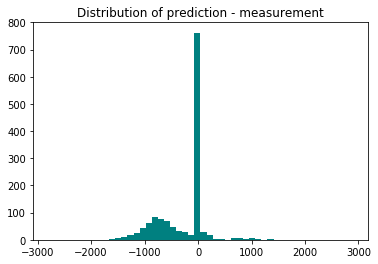

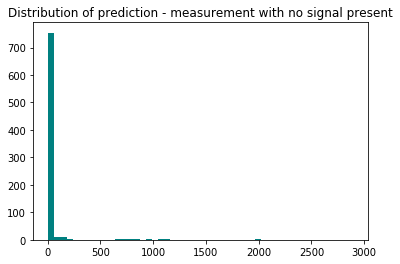

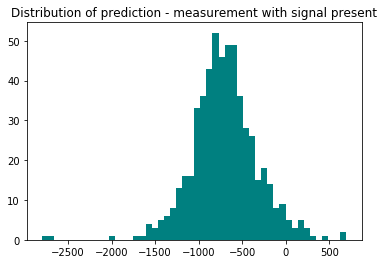

In [33]:

pred = model.predict(X_np)

diff_power = pred[:,2] - y_np[:,2]
diff_clean = pred[:,2][y_np[:,2] == 0] - y_np[:,2][y_np[:,2] == 0]
diff_signal = pred[:,2][y_np[:,2] != 0] - y_np[:,2][y_np[:,2] != 0]


print(pred.shape)

plt.hist(diff_power,bins=50, color='teal')
plt.title("Distribution of prediction - measurement")
plt.show()

plt.hist(diff_clean,bins=50, color='teal')
plt.title("Distribution of prediction - measurement with no signal present")
plt.show()

plt.hist(diff_signal,bins=50, color='teal')
plt.title("Distribution of prediction - measurement with signal present")
plt.show()

As seen previously, the model seems to predict fairly well whether or not a signal is present. However, it systematically underestimates the average power of the signal by around 700W. It does this however, with a large degree of confidence. Perhaps a different normalization would allow it to shift the distribution.

Best accuracy:  0.991928251121


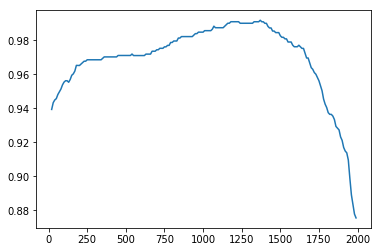

In [41]:
#F1 score = 2*(recall*precision)/(recall+precision)
signal_present_gold = np.zeros(pred.shape[0])
signal_present_gold[np.where(y_np[:,2] > 0)] = 1
accs = []
thresholds = np.arange(20,2000,10)

for i in thresholds:
    signal_present_pred = np.zeros(pred.shape[0])
    signal_present_pred[np.where(pred[:,2] >= i)] = 1
    
    precision = signal_present_gold[signal_present_gold + signal_present_pred == 2].shape[0]/np.sum(signal_present_pred)
    recall = signal_present_gold[signal_present_gold + signal_present_pred == 2].shape[0]/np.sum(signal_present_gold)
    f1 = 2*(recall*precision)/(recall+precision)
    
    accs.append(f1)
    
print("Best accuracy: ", max(accs))
plt.plot(thresholds,accs)
plt.xticks = thresholds
plt.show()


Thresholding around 1300W allows for a >99% accuracy.